# TensorFlow2 DenseNet-LSTM (RGB)

## 1.导入数据
使用BROOK数据集 

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
import tensorflow_addons as tfa
import os.path 
from tensorflow_addons.layers import CRF

In [3]:
#txt_file = 'sc/train23.txt'
txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspaths.append(filename)
        speeds.append(int(speed))
    
y_train = np.array(speeds)



In [4]:
max_unit = np.max(y_train)

In [5]:
#txt_file = 'sc/test23.txt'
txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspath2.append(filename)
        speeds.append(int(speed))
y_test = np.array(speeds)
        

In [6]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
#     img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [7]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
#     img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [9]:
validation_set = (x_test, y_test)

## CNN和LSTM结果合并

In [10]:
from tensorflow.keras import layers
model = keras.Sequential()

In [11]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

In [12]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(img_input)
lstm_layer = layers.LSTM(50, return_sequences=False)(reshape)
dense2 = layers.Dense(64)(lstm_layer)

In [13]:
merged_layer = layers.concatenate([dense1, dense2])
# merged_layer = dense1
outt = layers.Dense(max_unit+1,activation='softmax')(merged_layer)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 densenet201 (Functional)       (None, 1, 1, 1920)   18321984    ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1024, 3)      0           ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 1920)         0           ['densenet201[0][0]']            
                                                                                              

In [14]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=200, validation_data = validation_set)

Epoch 1/200
850/850 [==============================] - 1063s 1s/step - loss: 2.3632 - accuracy: 0.4355 - val_loss: 3.7623 - val_accuracy: 0.3509
Epoch 2/200
850/850 [==============================] - 1071s 1s/step - loss: 2.0576 - accuracy: 0.4667 - val_loss: 1.9946 - val_accuracy: 0.4669
Epoch 3/200
850/850 [==============================] - 1087s 1s/step - loss: 1.9057 - accuracy: 0.4836 - val_loss: 1.8625 - val_accuracy: 0.4761
Epoch 4/200
850/850 [==============================] - 1122s 1s/step - loss: 1.7696 - accuracy: 0.5004 - val_loss: 3574826.0000 - val_accuracy: 0.3156
Epoch 5/200
850/850 [==============================] - 1113s 1s/step - loss: 1.8890 - accuracy: 0.4844 - val_loss: 1.8416 - val_accuracy: 0.4870
Epoch 6/200
850/850 [==============================] - 1112s 1s/step - loss: 1.6403 - accuracy: 0.5187 - val_loss: 1.7676 - val_accuracy: 0.4900
Epoch 7/200
850/850 [==============================] - 1110s 1s/step - loss: 1.5455 - accuracy: 0.5337 - val_loss: 1.6469 - 

850/850 [==============================] - 1119s 1s/step - loss: 0.2627 - accuracy: 0.9094 - val_loss: 3.2229 - val_accuracy: 0.5564
Epoch 58/200
850/850 [==============================] - 1116s 1s/step - loss: 0.2608 - accuracy: 0.9088 - val_loss: 1.8381 - val_accuracy: 0.6387
Epoch 59/200
850/850 [==============================] - 1119s 1s/step - loss: 0.2508 - accuracy: 0.9129 - val_loss: 1.8932 - val_accuracy: 0.6286
Epoch 60/200
850/850 [==============================] - 1114s 1s/step - loss: 0.2358 - accuracy: 0.9172 - val_loss: 2.9144 - val_accuracy: 0.5137
Epoch 61/200
850/850 [==============================] - 1114s 1s/step - loss: 0.2391 - accuracy: 0.9178 - val_loss: 1.9850 - val_accuracy: 0.6222
Epoch 62/200
850/850 [==============================] - 1126s 1s/step - loss: 0.2311 - accuracy: 0.9195 - val_loss: 2.3013 - val_accuracy: 0.5883
Epoch 63/200
850/850 [==============================] - 1118s 1s/step - loss: 0.2211 - accuracy: 0.9237 - val_loss: 1.9328 - val_accuracy

850/850 [==============================] - 1092s 1s/step - loss: 0.1123 - accuracy: 0.9633 - val_loss: 2.4082 - val_accuracy: 0.6395
Epoch 114/200
850/850 [==============================] - 1100s 1s/step - loss: 0.0897 - accuracy: 0.9707 - val_loss: 2.8616 - val_accuracy: 0.6179
Epoch 115/200
850/850 [==============================] - 1087s 1s/step - loss: 0.1015 - accuracy: 0.9662 - val_loss: 2.6681 - val_accuracy: 0.6138
Epoch 116/200
850/850 [==============================] - 1085s 1s/step - loss: 0.1021 - accuracy: 0.9662 - val_loss: 2.5697 - val_accuracy: 0.6381
Epoch 117/200
850/850 [==============================] - 1086s 1s/step - loss: 0.0983 - accuracy: 0.9679 - val_loss: 2.5604 - val_accuracy: 0.6345
Epoch 118/200
850/850 [==============================] - 1087s 1s/step - loss: 0.0958 - accuracy: 0.9691 - val_loss: 3.0436 - val_accuracy: 0.5855
Epoch 119/200
850/850 [==============================] - 1084s 1s/step - loss: 0.0891 - accuracy: 0.9707 - val_loss: 2.8425 - val_ac

Epoch 169/200
850/850 [==============================] - 1168s 1s/step - loss: 0.0587 - accuracy: 0.9809 - val_loss: 3.1618 - val_accuracy: 0.6083
Epoch 170/200
850/850 [==============================] - 1115s 1s/step - loss: 0.3990 - accuracy: 0.8936 - val_loss: 4.1096 - val_accuracy: 0.4803
Epoch 171/200
850/850 [==============================] - 1121s 1s/step - loss: 0.2012 - accuracy: 0.9340 - val_loss: 1.9838 - val_accuracy: 0.6655
Epoch 172/200
850/850 [==============================] - 1152s 1s/step - loss: 0.0547 - accuracy: 0.9831 - val_loss: 2.2616 - val_accuracy: 0.6595
Epoch 173/200
850/850 [==============================] - 1170s 1s/step - loss: 0.0759 - accuracy: 0.9870 - val_loss: 2.4139 - val_accuracy: 0.6639
Epoch 174/200
850/850 [==============================] - 1155s 1s/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 2.7112 - val_accuracy: 0.6592
Epoch 175/200
850/850 [==============================] - 1101s 1s/step - loss: 0.0316 - accuracy: 0.9904 - val_loss: 2

In [15]:
model.evaluate(x=x_test, y=y_test,verbose=1)

224/224 [==============================] - 55s 234ms/step - loss: 2.9782 - accuracy: 0.6434


[2.9781646728515625, 0.6434151530265808]

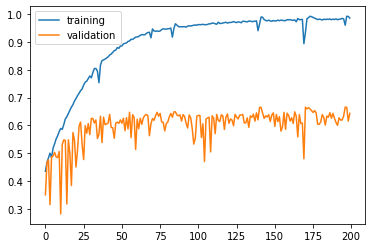

In [16]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [17]:
np.max(history2.history['accuracy'])

0.9921459555625916

In [18]:
np.max(history2.history['val_accuracy'])

0.666015625